In [ ]:
!pip -q install spacy transformers accelerate tqdm matplotlib

In [ ]:
import pandas as pd
import numpy as np
import spacy
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import matplotlib.pyplot as plt

In [ ]:
# ---------- Konfigurasi ----------
CSV_PATH = "garudaindonesia_news_cleaned_simple.csv"  # ganti sesuai lokasi
TEXT_COL = "konten_normalized"   # kolom tanpa stopword removal
OUT_DIR  = "/content"
MAX_DOCS = None                  # None = semua dokumen; isi angka untuk sampling (mis. 1000)
BATCH_SIZE = 32                  # batch kalimat per inferensi HF pipeline

MODEL_NAME = "cahya/bert-base-indonesian-NER"  # IndoBERT NER (HF)
AGG_STRAT  = "simple"

In [ ]:
df = pd.read_csv(CSV_PATH)
assert TEXT_COL in df.columns, f"Kolom '{TEXT_COL}' tidak ditemukan."
texts = df[TEXT_COL].astype(str).fillna("").tolist()
if MAX_DOCS is not None:
    texts = texts[:MAX_DOCS]
print(f"Jumlah dokumen: {len(texts)}")

Jumlah dokumen: 469


In [ ]:
# ---------- spaCy: sentencizer ringan ----------
# Kita pakai model kosong multilingual + rule-based sentencizer (ringan & cepat)
nlp = spacy.blank("xx")
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

In [ ]:
# ---------- HF pipeline: IndoBERT NER ----------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

use_device = 0 if torch.cuda.is_available() else -1
print("Using device:", "cuda:0" if use_device == 0 else "cpu")

ner = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy=AGG_STRAT,
    device=use_device   # ✅ gunakan GPU kalau ada
)

Some weights of the model checkpoint at cahya/bert-base-indonesian-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Using device: cpu


In [ ]:
# --- Helper: pecah teks berdasarkan jumlah token WordPiece ---
def chunk_by_tokens(text, tokenizer, max_tokens=510):
    """
    Memecah 'text' menjadi list (chunk_text, start_char, end_char),
    masing-masing dijamin <= max_tokens subword (tanpa special tokens).
    """
    words = text.split()
    chunks = []
    cur_words = []
    cur_start = 0
    # pointer karakter untuk setiap kata (agar offset stabil)
    # bangun indeks start_char tiap kata
    offs = []
    pos = 0
    for w in words:
        start = text.find(w, pos)
        offs.append(start)
        pos = start + len(w)

    cur_token_count = 0
    for i, w in enumerate(words):
        # hitung token untuk kata berikut
        n_tok = len(tokenizer.tokenize(w))
        if n_tok == 0:  # kata kosong
            continue

        # kalau menambah kata ini melewati batas, tutup chunk dulu
        if cur_token_count + n_tok > max_tokens and cur_words:
            chunk_text = " ".join(cur_words)
            start_char = offs[i - len(cur_words)]
            end_char = offs[i - 1] + len(words[i - 1])
            chunks.append((chunk_text, start_char, end_char))
            # reset
            cur_words = []
            cur_token_count = 0

        cur_words.append(w)
        cur_token_count += n_tok

    # sisa terakhir
    if cur_words:
        start_char = offs[len(words) - len(cur_words)]
        end_char = offs[len(words) - 1] + len(words[-1])
        chunks.append((" ".join(cur_words), start_char, end_char))

    # fallback jika teks kosong
    if not chunks and text.strip():
        chunks = [(text, 0, len(text))]
    return chunks


In [ ]:
rows = []
for doc_id, text in tqdm(list(enumerate(texts)), total=len(texts), desc="NER (spaCy+IndoBERT)"):
    if not text.strip():
        continue
    doc = nlp(text)

    # siapkan batch kalimat dan offset awal tiap kalimat terhadap dokumen
    sents = list(doc.sents)
    sent_texts = [s.text for s in sents]
    sent_starts = [s.start_char for s in sents]  # untuk offset global

        # ---- Jalankan NER dengan chunking aman token ----
    for sent_idx, sent in enumerate(sents):
        pieces = chunk_by_tokens(sent.text, tokenizer, max_tokens=510)  # <= 510 subword
        if not pieces:
            continue

        # batching per beberapa potongan agar efisien
        for p_start in range(0, len(pieces), BATCH_SIZE):
            batch = pieces[p_start:p_start+BATCH_SIZE]
            batch_texts = [p[0] for p in batch]
            batch_l_offsets = [p[1] for p in batch]  # offset lokal terhadap dokumen (mulai kalimat+chunk)
            # offset global = start kalimat di dokumen + offset lokal potongan
            batch_offsets = [sent.start_char + lo for lo in batch_l_offsets]

            results = ner(batch_texts)  # tidak perlu argumen truncation
            for k, ents in enumerate(results):
                base_offset = batch_offsets[k]
                if not ents:
                    continue
                for ent in ents:
                    rows.append({
                        "doc_id": doc_id,
                        "sent_id": sent_idx,                       # tetap pakai ID kalimat asli
                        "ent_text": ent.get("word", ""),
                        "ent_label": ent.get("entity_group", ent.get("entity", "")),
                        "score": float(ent.get("score", np.nan)),
                        "start_char": int(base_offset + ent.get("start", 0)),
                        "end_char": int(base_offset + ent.get("end", 0)),
                    })

ner_df = pd.DataFrame(rows)
print("Preview hasil NER:")
print(ner_df.head())
NER_PATH = f"{OUT_DIR}/ner_spacy_indobert_cahya.csv"
ner_df.to_csv(NER_PATH, index=False)
print("Saved:", NER_PATH)

NER (spaCy+IndoBERT):   0%|          | 0/469 [00:00<?, ?it/s]

Preview hasil NER:
   doc_id  sent_id            ent_text ent_label     score  start_char  \
0       0        0    garuda indonesia       ORG  0.920743           0   
1       0        0                 rup       EVT  0.490043          25   
2       0        0               ##slb       PRD  0.394727          28   
3       0        0  singapore airlines       ORG  0.856513          55   
4       0        0           september       DAT  0.953419          80   

   end_char  
0        16  
1        28  
2        31  
3        73  
4        89  
Saved: /content/ner_spacy_indobert_cahya.csv



Distribusi label entitas:
   ent_label  count
0        ORG   9804
1        PRD   5379
2        PER   2665
3        GPE   2559
4        NOR    897
5        EVT    753
6        DAT    747
7        MON    740
8        CRD    624
9        LAW    302
10       FAC    220
11       LOC    173
12       ORD    173
13       QTY     67
14       TIM     29
15       PRC     26
16       WOA     21
17       REG     20


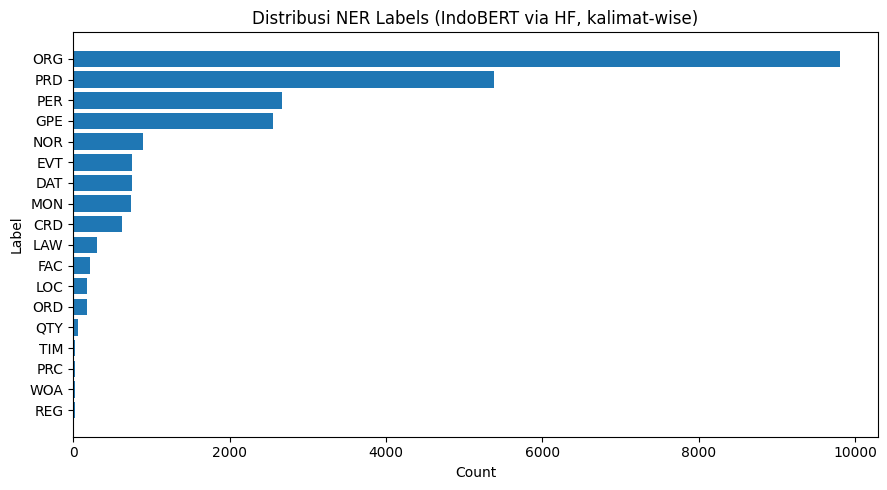


Top 20 entitas untuk CRD:
   ent_label  _norm_ent  freq
13       CRD       satu   173
3        CRD        dua   155
19       CRD       tiga    66
4        CRD      empat    48
10       CRD       lima    46
7        CRD      kedua    35
20       CRD      tujuh    32
5        CRD       enam    19
2        CRD    delapan    17
6        CRD       juta     5
11       CRD        one     5
18       CRD    sepuluh     5
1        CRD    belasan     3
8        CRD     kelima     3
9        CRD     ketiga     3
16       CRD   sembilan     2
21       CRD        two     2
0        CRD      belas     1
12       CRD     persen     1
14       CRD  satu juta     1

Top 20 entitas untuk DAT:
   ent_label   _norm_ent  freq
52       DAT       maret    68
41       DAT        juni    56
23       DAT       april    46
43       DAT       kamis    46
34       DAT       jumat    45
61       DAT        rabu    42
73       DAT      selasa    42
67       DAT       sabtu    39
31       DAT        juli    37
78    

In [ ]:
if not ner_df.empty:
    label_counts = ner_df["ent_label"].value_counts().reset_index()
    label_counts.columns = ["ent_label", "count"]
    print("\nDistribusi label entitas:")
    print(label_counts)
     # ---------- Visualisasi ----------
    plt.figure(figsize=(9,5))
    plt.barh(label_counts["ent_label"][::-1], label_counts["count"][::-1])
    plt.xlabel("Count")
    plt.ylabel("Label")
    plt.title("Distribusi NER Labels (IndoBERT via HF, kalimat-wise)")
    plt.tight_layout()
    plt.show()
    # ---------- Top entitas per label ----------
    # normalisasi ringan untuk penggabungan
    ner_df["_norm_ent"] = (ner_df["ent_text"]
                           .str.replace(r"\s+", " ", regex=True)
                           .str.strip())
    top_ents = (ner_df
                .groupby(["ent_label","_norm_ent"]).size()
                .reset_index(name="freq")
                .sort_values(["ent_label","freq"], ascending=[True, False]))
    TOP_N = 20
    for lbl in top_ents["ent_label"].unique():
        print(f"\nTop {TOP_N} entitas untuk {lbl}:")
        print(top_ents[top_ents["ent_label"] == lbl].head(TOP_N))

    TOPENTS_PATH = f"{OUT_DIR}/ner_spacy_indobert_top_entities.csv"
    top_ents.to_csv(TOPENTS_PATH, index=False)
    print("Saved:", TOPENTS_PATH)
else:
    print("Tidak ada entitas terdeteksi — cek kualitas teks atau coba model lain.")